# Yelp Review Prediction
Objective: Construct and train a Neural Network that would be able to predict the number of star ratings from a Yelp review.    
Dataset used: https://www.yelp.com/dataset/challenge  

Steps:  
1) Data Preprocessing  
2) Deep Learning Preprocessing  
3) Network Training  
4) Network Testing  

In [50]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
from langdetect import detect
import time
import numpy as np
import pandas as pd
from pandas_ml import ConfusionMatrix
import seaborn

import sklearn as sk
from sklearn.model_selection import train_test_split
import numpy as np
import json

import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
import pickle

import matplotlib.pyplot as plt
import random
import nltk, re, time
from nltk.corpus import stopwords
import string
from collections import defaultdict
from collections import namedtuple
from contractions import get_contractions

import operator
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import tensor_array_ops
print('TensorFlow Version: {}'.format(tf.__version__))
import os 
alreadyPickled = False

TensorFlow Version: 1.5.0


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Variable Initialization

In [4]:
embedding_dim = 300
num_layers = 2
num_classes = 6
epochs = 5
batch_size = 64
rnn_size = 64
num_layers = 2

learning_rate = 0.005

keep_probability = 0.8
max_sequence_length = 750

IS_TRAINING = True
IS_TESTING = False

# Data Loading
If the data is already pickled, then can skip embedding and data processing

In [5]:
def picklefiles(filename, stuff):
    save_stuff = open(filename, "wb")
    pickle.dump(stuff, save_stuff)
    save_stuff.close()
def loadfiles(filename):
    saved_stuff = open(filename,"rb")
    stuff = pickle.load(saved_stuff)
    saved_stuff.close()
    return stuff

## Data Preprocessing
The following few cells preprocess the data for me. Clean test defines a function where it removes stop_words (found here https://gist.github.com/sebleier/554280). These words typically have no beneficial meaning to any reviews and are thus wasted features. I also strip punctuation and turn everything lower case. These procedures can be considered pretty standard

In [6]:
def clean_text(text):
    text = text.lower()    
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [7]:
restId = []
for line in open('./data/dataset/business.json', 'r'):
    data = json.loads(line)
    if 'Restaurants' in data['categories'] or 'Food' in data['categories']:
        restId.append(data['business_id'])
print("There are %d restaurants" % (len(restId)))

There are 69047 restaurants


### Grabbing the reviews and star ratings
Here, I narrow down my reviews to english only reviews. I do this since restaurants make up around 60% of the yelp reviews. This way review types and wording may stay relatively similar for more accurate training

In [8]:
contractions = get_contractions()

revs_list = [[]]
stars_list = [[]]
num = 1000000 # Number of review read
k = 0 # Count
nolang = [[]]
for line in open('./data/dataset/review.json', 'r', encoding='utf-8'):
    if k >= num:
        break
    data = json.loads(line)
    text = data['text']
    star = data['stars']
    ID = data['business_id']
    # Check language
    if text == None:
        continue
    if star == None:
        continue
    if ID not in restId:
        continue
    try:
        if detect(text) == 'en':
            revs_list.append(clean_text(text))
            stars_list.append(star)
            k += 1
            # Notify for every 5000 reviews
            if len(revs_list) % 5000 == 0:
                print(len(revs_list), k)
    except:
        nolang.append(text)

5000 4999
10000 9999
15000 14999
20000 19999
25000 24999
30000 29999
35000 34999
40000 39999
45000 44999
50000 49999
55000 54999
60000 59999
65000 64999
70000 69999
75000 74999
80000 79999
85000 84999
90000 89999
95000 94999
100000 99999
105000 104999
110000 109999
115000 114999
120000 119999
125000 124999
130000 129999
135000 134999
140000 139999
145000 144999
150000 149999
155000 154999
160000 159999
165000 164999
170000 169999
175000 174999
180000 179999
185000 184999
190000 189999
195000 194999
200000 199999
205000 204999
210000 209999
215000 214999
220000 219999
225000 224999
230000 229999
235000 234999
240000 239999
245000 244999
250000 249999
255000 254999
260000 259999
265000 264999
270000 269999
275000 274999
280000 279999
285000 284999
290000 289999
295000 294999
300000 299999
305000 304999
310000 309999
315000 314999
320000 319999
325000 324999
330000 329999
335000 334999
340000 339999
345000 344999
350000 349999
355000 354999
360000 359999
365000 364999
370000 369999
375000

In [9]:
print(revs_list[1])
print(len(revs_list), len(stars_list))

love staff love meat love place prepare long line around lunch dinner hours ask want meat lean something maybe cannot remember say want fatty get half sour pickle hot pepper hand cut french fries
1000001 1000001


In [11]:
np_revs = np.asarray([revs_list]).T
np_stars = np.asarray([stars_list]).T
stacked_revs = np.hstack((np_revs, np_stars))
categories = ['text', 'stars']
print(np_revs.shape, np_stars.shape, stacked_revs.shape)
df_reviews_processing = pd.DataFrame(stacked_revs, columns=categories)
print(df_reviews_processing.shape)
print(df_reviews_processing.head())

(1000001, 1) (1000001, 1) (1000001, 2)
(1000001, 2)
                                                text stars
0                                                 []    []
1  love staff love meat love place prepare long l...     5
2  super simple place amazing nonetheless around ...     5
3  small unassuming place changes menu every ofte...     5
4  lester located beautiful neighborhood since 19...     5


In [12]:
df_reviews_processing[['stars']] = df_reviews_processing[['stars']].apply(pd.to_numeric)

# Grabbing only numbers that are of numerical value (get rid of None, NaN, etc)
print("Before Dropping Nones: Shape %d,%d" % (df_reviews_processing.shape[0], df_reviews_processing.shape[1]))

df_reviews_processing = df_reviews_processing[np.isfinite(df_reviews_processing['stars'])]
df_reviews = df_reviews_processing[np.isfinite(df_reviews_processing['stars'])]
df_reviews = df_reviews.dropna()
df_reviews = df_reviews.reset_index(drop=True)

print("After Dropping Nones: Shape %d,%d" % (df_reviews.shape[0], df_reviews.shape[1]))

df_reviews.to_csv("./csvs/reviews_df_processed.csv", encoding='utf-8')

Before Dropping Nones: Shape 1000001,2
After Dropping Nones: Shape 1000000,2


# Balance the Dataset
Want to balance the dataset, such that we have an equal number of reviews for each different category.  
For example, if our distribution of reviews is [200,500,100,300,400], for [1,2,3,4,5] stars, respectively, then I will only take 100 of each review  
I do this so we have an equal representation of all labels when he train and test

In [13]:
def balance_dataframe(df, category=['stars']):
    """
    :param df: pandas.DataFrame
    :param categorical_columns: iterable of categorical columns names contained in {df}
    :return: balanced pandas.DataFrame
    """    
    if category is None or not all([col in df.columns for col in category]):
        raise ValueError('Please provide one or more columns containing categorical variables')

    lowest_count = df.groupby(category).apply(lambda x: x.shape[0]).min()
    df = df.groupby(category).apply( 
        lambda x: x.sample(lowest_count)).drop(category, axis=1).reset_index().set_index('level_1')

    df.sort_index(inplace=True)

    return df

In [15]:
df_reviews = pd.read_csv("./csvs/reviews_df_processed.csv")
df_reviews['len'] = df_reviews.text.str.len()

df_reviews = df_reviews[df_reviews['len'].between(10, 4000)]
df_reviews[['stars']] = df_reviews[['stars']].apply(pd.to_numeric)

print("(pre) 1 star ratings: %d" % (len(df_reviews[df_reviews.stars == 1])))
print("(pre) 2 star ratings: %d" % (len(df_reviews[df_reviews.stars == 2])))
print("(pre) 3 star ratings: %d" % (len(df_reviews[df_reviews.stars == 3])))
print("(pre) 4 star ratings: %d" % (len(df_reviews[df_reviews.stars == 4])))
print("(pre) 5 star ratings: %d" % (len(df_reviews[df_reviews.stars == 5])))

df_balanced = balance_dataframe(df_reviews, 
                                category=['stars'])

df_balanced.to_csv('balanced_reviews1000.csv', encoding='utf-8')
print("(post) 1 star ratings: %d" % (len(df_balanced[df_balanced.stars == 1])))
print("(post) 2 star ratings: %d" % (len(df_balanced[df_balanced.stars == 2])))
print("(post) 3 star ratings: %d" % (len(df_balanced[df_balanced.stars == 3])))
print("(post) 4 star ratings: %d" % (len(df_balanced[df_balanced.stars == 4])))
print("(post) 5 star ratings: %d" % (len(df_balanced[df_balanced.stars == 5])))




(pre) 1 star ratings: 114331
(pre) 2 star ratings: 94828
(pre) 3 star ratings: 134510
(pre) 4 star ratings: 269225
(pre) 5 star ratings: 387071
(post) 1 star ratings: 94828
(post) 2 star ratings: 94828
(post) 3 star ratings: 94828
(post) 4 star ratings: 94828
(post) 5 star ratings: 94828


In [16]:
print(df_balanced.head())
print(np.percentile(df_balanced.len, 80))
print(np.percentile(df_balanced.len, 85))
print(np.percentile(df_balanced.len, 87.5))
print(np.percentile(df_balanced.len, 95))
max_sequence_length = 750

         stars  Unnamed: 0                                               text  \
level_1                                                                         
4          4.0           4  love coming yes place always needs floor swept...   
6          4.0           6  would guess would able get fairly decent vietn...   
8          3.0           8  bad love gluten free vegan version cheese curd...   
9          4.0           9  currently parents new favourite restaurant com...   
10         3.0          10  server little rude ordered calamari duck confi...   

           len  
level_1         
4        314.0  
6        376.0  
8        153.0  
9        266.0  
10       107.0  
566.0
660.0
721.0
1045.0


# Embeddings
Using ConceptNet Numberbatch instead of GLoVE (supposedly outperforms GLoVE embeddings)  
https://github.com/commonsense/conceptnet-numberbatch
  
On top of the embeddings, we also keep track of commonly used words in the reviews that Embeddings don't cover. This way we could have higher test accuracy when words we come across words like these. This is specified by a threshold value. Currently, threshold is set to 20 occuraces.  
  
  
We also process the reviews a bit more, sorting them into comparable lengths. This way, there is less padding necessary and (possibly) faster computation time when training/testing

In [17]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [18]:
word_counts = {}
count_words(word_counts, df_balanced.text)            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 143090


In [19]:
embed_path='./embeddings/numberbatch-en.txt'
def load_embeddings(path='./embeddings/numberbatch-en.txt'):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    return embeddings_index

embeddings_index = load_embeddings(embed_path)

# Tokenizer
Here we will create a dictionary __word2int__ that will map each word to respective value.

In [21]:
#dictionary to tokenizer words
word2int = {} 
threshold = 20
token_index = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        word2int[word] = token_index
        token_index += 1

# Special tokens that will be added to our vocab
special_characters = ["<unk>","<pad>"]   

# Add codes to vocab
for c in special_characters:
    word2int[c] = len(word2int)
    
usage_ratio = round(len(word2int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(word2int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 143090
Number of words we will use: 66738
Percent of words we will use: 46.64%


In [22]:
# Need to use 300 for embedding dimensions to match CN's vectors.
embedding_dim = 300
nb_words = len(word2int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in word2int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in embeddings, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(word2int). 
print(len(word_embedding_matrix), len(word2int))

66738 66738


# Tokenize Words

In [23]:
def convert_to_ints(text, pred=False):
    if pred:
        seq = []
        for word in text.split():
            if word in word2int:
                seq.append(word2int[word])
            else:
                seq.append(word2int["<unk>"])
        return seq
    else:
        seq = []
        for s in text:
            temp_seq = []
            for word in s.split():
                if word in word2int:
                    temp_seq.append(word2int[word])
                else:
                    temp_seq.append(word2int["<unk>"])
            seq.append(temp_seq)
        return seq

In [24]:
seq = convert_to_ints(df_balanced['text'])

In [25]:
# Split the ratings into One-Hot representation
ratings = df_balanced.stars.values.astype(int)
ratings_cat = tf.keras.utils.to_categorical(ratings)
X_train, X_test, y_train, y_test = train_test_split(seq, ratings_cat, test_size=0.2, random_state=9)
with pd.HDFStore('x_y_test_train.h5') as h:
    h['X_train'] = pd.DataFrame(X_train)
    h['X_test'] = pd.DataFrame(X_test)
    h['y_train'] = pd.DataFrame(y_train)
    h['y_test'] = pd.DataFrame(y_test)

# Getting Batches
Gets batches. These will be called later to then fill our X and y placeholders

In [82]:
def pad_batch(batch):
    # Want to pad this way since tensorflow preprocessing pads with 0's, which can eventually lead to zero tensors
    lengths = []
    for text in batch:
        lengths.append(len(text))
    max_length = max(lengths)
    pad_text = tf.keras.preprocessing.sequence.pad_sequences(batch, 
                                                             maxlen=max_length, 
                                                             padding='post', 
                                                             value=word2int['<pad>'])
    return pad_text

def get_batches(x, y, batch_size):
    # Make sure to not exceed amount of data
    for batch_i in range(0, len(x)//batch_size):
        start = batch_i * batch_size
        end = start+batch_size
        batch_x = x[start:end]
        labels = y[start:end]
        pad_batch_x = np.array(pad_batch(batch_x))
        yield pad_batch_x, labels
        
def get_test_batches(x, batch_size):
    for batch_i in range(0, len(x)//batch_size):
        start = batch_i * batch_size
        end = start+batch_size
        batch = x[start:end]
        pad_batch_test = np.array(pad_batch(batch))
        yield pad_batch_test

In [69]:
if alreadyPickled == False:
    
    picklefiles("./data/pickles/balanced_reviews.p",df_balanced)
    picklefiles("./data/pickles/category_ratings.p",ratings_cat)
    picklefiles("./data/pickles/word_embedding_matrix.p",word_embedding_matrix)
    picklefiles("./data/pickles/word2int.p", word2int)
    
if alreadyPickled == True:
    
    word_embedding_matrix = loadfiles("./data/pickles/word_embedding_matrix.p")
    ratings_cat = loadfiles("./data/pickles/category_ratings.p")
    df_balanced = pd.read_csv('balanced_reviews.csv')
    balanced_reviews = loadfiles("./data/pickles/balanced_reviews.p")
    word2int = loadfiles('./data/pickles/word2int.p')
    with pd.HDFStore('x_y_test_train.h5') as h:
        X_train = h['X_train'].values
        X_test = h['X_test'].values
        y_train = h['y_train'].values
        y_test = h['y_test'].values

# Building the Graph
Here we start building our computational graph. We use a 2 layer GRU Recurrent Neural Network. We define placeholders for learning rate and dropout since these are variables that we could potentially want to vary.

In [70]:
def model_inputs():
    # Should be [batch_size x review length]
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    # Should be [batch_size x num_classes]
    labels = tf.placeholder(tf.int32, [None, None], name='labels')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    return input_data, labels, lr, keep_prob

In [71]:
# Reset the graph
tf.reset_default_graph()

In [72]:
train_graph = tf.Graph()
with train_graph.as_default():
    with tf.name_scope("inputs"):
        input_data, labels, lr, keep_prob = model_inputs()
        weight = tf.Variable(tf.truncated_normal([rnn_size, num_classes], stddev=(1/np.sqrt(rnn_size*num_classes))))
        bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))

    embeddings = word_embedding_matrix
    embs = tf.nn.embedding_lookup(embeddings, input_data)

    with tf.name_scope("RNN_Layers"):
        
        stacked_rnn = []
        for layer in range(num_layers):
            cell_fw = tf.contrib.rnn.GRUCell(rnn_size)
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw,
                                                    output_keep_prob=keep_prob)
            stacked_rnn.append(cell_fw)
        multilayer_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn, state_is_tuple=True)

        
    with tf.name_scope("init_state"):
        initial_state = multilayer_cell.zero_state(batch_size, tf.float32)

    with tf.name_scope("Forward_Pass"):
        output, final_state = tf.nn.dynamic_rnn(multilayer_cell,
                                           embs,
                                           dtype=tf.float32)

    with tf.name_scope("Predictions"):
        last = output[:, -1, :]
        predictions = tf.exp(tf.matmul(last, weight) + bias)
        tf.summary.histogram('predictions', predictions)
        
    with tf.name_scope('cost'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=labels))        
        tf.summary.scalar('cost', cost)
    
    # Optimizer 
    with tf.name_scope('train'):    
        optimizer = tf.train.AdamOptimizer(lr).minimize(cost)
    
    # Predictions comes out as 6 output layer, so need to "change" to one hot
    with tf.name_scope("accuracy"):
        correctPred = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
    
    export_nodes = ['input_data', 'labels', 'keep_prob', 'lr', 'initial_state', 'final_state',
                    'accuracy', 'predictions', 'cost', 'optimizer', 'merged']
    
    merged = tf.summary.merge_all()
    
print("Graph is built.")
graph_location = "./graph"

Graph = namedtuple('train_graph', export_nodes)
local_dict = locals()
graph = Graph(*[local_dict[each] for each in export_nodes])
    
print(graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(train_graph)

Graph is built.
./graph


## Defining Hyperparameters

In [73]:
learning_rate_decay = 0.95
min_learning_rate = 0.0005
display_step = 20 # Check training loss after every 20 batches
stop_early = 0 
stop = 3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 8 # Make 8 update checks per epoch
update_check = (len(seq)//batch_size//per_epoch)-1
keep_probability = 0.75
update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model
shuffle = True

In [74]:
def shuffle_data(X, y):
    whole_data = np.insert(X, 0, y, axis=1)
    np.random.shuffle(whole_data)
    labels = whole_data[0,:]
    data = whole_data[1,:]
    return data, labels

# Training the Model
I've been keeping track of the tensorboard summaries so it'll allow me to visualize the training process. 

In [ ]:
load = True

In [79]:
checkpoint = "./saves/best_model.ckpt" 
if load:
    loader = tf.train.import_meta_graph("./" + checkpoint + '.meta')
if IS_TRAINING:
    with tf.Session(graph=train_graph) as sess:
        if load:
            loader.restore(sess, checkpoint)
        else:
            sess.run(tf.global_variables_initializer())

        train_writer = tf.summary.FileWriter('./summaries' + '/train', sess.graph)

        for epoch_i in range(1, epochs+1):
            state = sess.run(graph.initial_state)

            update_loss = 0
            batch_loss = 0

            for batch_i, (x, y) in enumerate(get_batches(X_train, y_train, batch_size)):
                if batch_i == 1:
                    print("Starting")
                feed = {graph.input_data: x,
                        graph.labels: y,
                        graph.keep_prob: keep_probability,
                        graph.initial_state: state, 
                        graph.lr: learning_rate}
                start_time = time.time()
                summary, loss, acc, state, _ = sess.run([graph.merged, 
                                                         graph.cost, 
                                                         graph.accuracy, 
                                                         graph.final_state, 
                                                         graph.optimizer], 
                                                        feed_dict=feed)
                if batch_i == 1:
                    print("Finished first")

                train_writer.add_summary(summary, epoch_i*batch_i + batch_i)

                batch_loss += loss
                update_loss += loss
                end_time = time.time()
                batch_time = end_time - start_time

                if batch_i % display_step == 0 and batch_i > 0:
                    print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Acc: {:>6.3f}, Seconds: {:>4.2f}'
                          .format(epoch_i,
                                  epochs, 
                                  batch_i, 
                                  len(X_train) // batch_size, 
                                  batch_loss / display_step,
                                  acc,
                                  batch_time*display_step))
                    batch_loss = 0

                if batch_i % update_check == 0 and batch_i > 0:
                    print("Average loss for this update:", round(update_loss/update_check,3))
                    summary_update_loss.append(update_loss)

                    # If the update loss is at a new minimum, save the model
                    if update_loss <= min(summary_update_loss):
                        print('New Record!') 
                        stop_early = 0
                        saver = tf.train.Saver() 
                        saver.save(sess, checkpoint)

                    else:
                        print("No Improvement.")
                        stop_early += 1
                        if stop_early == stop:
                            break
                    update_loss = 0


            # Reduce learning rate, but not below its minimum value
            learning_rate *= learning_rate_decay
            if learning_rate < min_learning_rate:
                learning_rate = min_learning_rate
            # Set shuffle to True if you want to shuffle data between epochs
            # This can add some randomness and potentially learn new patterns in data
#             if shuffle:
#                 X_train, y_train = shuffle_data(X_train, y_train)
            if stop_early == stop:
                print("Stopping Training.")
                break

INFO:tensorflow:Restoring parameters from ./saves/best_model.ckpt
Starting
Finished first
Epoch   1/5 Batch   20/5926 - Loss:  1.003, Acc:  0.641, Seconds: 11.68
Epoch   1/5 Batch   40/5926 - Loss:  0.953, Acc:  0.484, Seconds: 10.30
Epoch   1/5 Batch   60/5926 - Loss:  0.958, Acc:  0.516, Seconds: 10.22
Epoch   1/5 Batch   80/5926 - Loss:  0.938, Acc:  0.594, Seconds: 17.57
Epoch   1/5 Batch  100/5926 - Loss:  0.920, Acc:  0.641, Seconds: 14.56
Epoch   1/5 Batch  120/5926 - Loss:  0.909, Acc:  0.625, Seconds: 25.55
Epoch   1/5 Batch  140/5926 - Loss:  0.951, Acc:  0.609, Seconds: 20.59
Epoch   1/5 Batch  160/5926 - Loss:  0.950, Acc:  0.562, Seconds: 22.66
Epoch   1/5 Batch  180/5926 - Loss:  0.922, Acc:  0.594, Seconds: 51.26
Epoch   1/5 Batch  200/5926 - Loss:  0.893, Acc:  0.625, Seconds: 31.70
Epoch   1/5 Batch  220/5926 - Loss:  0.954, Acc:  0.562, Seconds: 17.27
Epoch   1/5 Batch  240/5926 - Loss:  0.926, Acc:  0.531, Seconds: 23.84
Epoch   1/5 Batch  260/5926 - Loss:  0.969, Ac

Epoch   1/5 Batch 2260/5926 - Loss:  0.943, Acc:  0.594, Seconds: 11.36
Epoch   1/5 Batch 2280/5926 - Loss:  0.883, Acc:  0.578, Seconds: 22.80
Epoch   1/5 Batch 2300/5926 - Loss:  0.906, Acc:  0.469, Seconds: 23.86
Epoch   1/5 Batch 2320/5926 - Loss:  0.939, Acc:  0.547, Seconds: 18.48
Epoch   1/5 Batch 2340/5926 - Loss:  0.869, Acc:  0.641, Seconds: 11.63
Epoch   1/5 Batch 2360/5926 - Loss:  0.929, Acc:  0.625, Seconds: 9.57
Epoch   1/5 Batch 2380/5926 - Loss:  0.898, Acc:  0.641, Seconds: 15.35
Epoch   1/5 Batch 2400/5926 - Loss:  0.890, Acc:  0.578, Seconds: 16.31
Epoch   1/5 Batch 2420/5926 - Loss:  0.906, Acc:  0.625, Seconds: 16.39
Epoch   1/5 Batch 2440/5926 - Loss:  0.871, Acc:  0.672, Seconds: 13.20
Epoch   1/5 Batch 2460/5926 - Loss:  0.935, Acc:  0.578, Seconds: 10.06
Epoch   1/5 Batch 2480/5926 - Loss:  0.940, Acc:  0.656, Seconds: 13.08
Epoch   1/5 Batch 2500/5926 - Loss:  0.905, Acc:  0.578, Seconds: 11.80
Epoch   1/5 Batch 2520/5926 - Loss:  0.914, Acc:  0.594, Seconds:

Epoch   1/5 Batch 4520/5926 - Loss:  0.868, Acc:  0.656, Seconds: 9.82
Epoch   1/5 Batch 4540/5926 - Loss:  0.888, Acc:  0.625, Seconds: 11.33
Epoch   1/5 Batch 4560/5926 - Loss:  0.970, Acc:  0.672, Seconds: 20.58
Epoch   1/5 Batch 4580/5926 - Loss:  0.878, Acc:  0.641, Seconds: 14.37
Epoch   1/5 Batch 4600/5926 - Loss:  0.875, Acc:  0.625, Seconds: 11.76
Epoch   1/5 Batch 4620/5926 - Loss:  0.858, Acc:  0.625, Seconds: 11.43
Average loss for this update: 0.901
New Record!
Epoch   1/5 Batch 4640/5926 - Loss:  0.918, Acc:  0.625, Seconds: 10.75
Epoch   1/5 Batch 4660/5926 - Loss:  0.868, Acc:  0.719, Seconds: 8.94
Epoch   1/5 Batch 4680/5926 - Loss:  0.886, Acc:  0.641, Seconds: 15.44
Epoch   1/5 Batch 4700/5926 - Loss:  0.899, Acc:  0.656, Seconds: 12.99
Epoch   1/5 Batch 4720/5926 - Loss:  0.938, Acc:  0.609, Seconds: 11.25
Epoch   1/5 Batch 4740/5926 - Loss:  0.883, Acc:  0.672, Seconds: 15.61
Epoch   1/5 Batch 4760/5926 - Loss:  0.907, Acc:  0.531, Seconds: 13.83
Epoch   1/5 Batch 

Epoch   2/5 Batch  860/5926 - Loss:  0.939, Acc:  0.656, Seconds: 10.30
Epoch   2/5 Batch  880/5926 - Loss:  0.911, Acc:  0.578, Seconds: 17.61
Epoch   2/5 Batch  900/5926 - Loss:  0.891, Acc:  0.562, Seconds: 10.38
Epoch   2/5 Batch  920/5926 - Loss:  0.873, Acc:  0.688, Seconds: 18.47
Average loss for this update: 0.889
New Record!
Epoch   2/5 Batch  940/5926 - Loss:  0.841, Acc:  0.641, Seconds: 17.79
Epoch   2/5 Batch  960/5926 - Loss:  0.893, Acc:  0.578, Seconds: 16.22
Epoch   2/5 Batch  980/5926 - Loss:  0.861, Acc:  0.625, Seconds: 13.08
Epoch   2/5 Batch 1000/5926 - Loss:  0.866, Acc:  0.578, Seconds: 12.84
Epoch   2/5 Batch 1020/5926 - Loss:  0.932, Acc:  0.594, Seconds: 7.13
Epoch   2/5 Batch 1040/5926 - Loss:  0.871, Acc:  0.641, Seconds: 12.31
Epoch   2/5 Batch 1060/5926 - Loss:  0.876, Acc:  0.609, Seconds: 14.44
Epoch   2/5 Batch 1080/5926 - Loss:  0.874, Acc:  0.562, Seconds: 10.60
Epoch   2/5 Batch 1100/5926 - Loss:  0.868, Acc:  0.594, Seconds: 11.87
Epoch   2/5 Batch

Epoch   2/5 Batch 3120/5926 - Loss:  0.890, Acc:  0.609, Seconds: 9.96
Epoch   2/5 Batch 3140/5926 - Loss:  0.880, Acc:  0.609, Seconds: 17.51
Epoch   2/5 Batch 3160/5926 - Loss:  0.872, Acc:  0.672, Seconds: 18.43
Epoch   2/5 Batch 3180/5926 - Loss:  0.876, Acc:  0.672, Seconds: 14.03
Epoch   2/5 Batch 3200/5926 - Loss:  0.863, Acc:  0.625, Seconds: 10.91
Epoch   2/5 Batch 3220/5926 - Loss:  0.898, Acc:  0.641, Seconds: 9.25
Epoch   2/5 Batch 3240/5926 - Loss:  0.867, Acc:  0.719, Seconds: 17.27
Epoch   2/5 Batch 3260/5926 - Loss:  0.890, Acc:  0.609, Seconds: 12.68
Epoch   2/5 Batch 3280/5926 - Loss:  0.875, Acc:  0.609, Seconds: 9.46
Epoch   2/5 Batch 3300/5926 - Loss:  0.905, Acc:  0.656, Seconds: 21.80
Epoch   2/5 Batch 3320/5926 - Loss:  0.868, Acc:  0.562, Seconds: 12.49
Epoch   2/5 Batch 3340/5926 - Loss:  0.855, Acc:  0.656, Seconds: 15.71
Epoch   2/5 Batch 3360/5926 - Loss:  0.854, Acc:  0.562, Seconds: 10.79
Epoch   2/5 Batch 3380/5926 - Loss:  0.878, Acc:  0.594, Seconds: 1

Epoch   2/5 Batch 5380/5926 - Loss:  0.870, Acc:  0.688, Seconds: 16.48
Epoch   2/5 Batch 5400/5926 - Loss:  0.871, Acc:  0.547, Seconds: 21.23
Epoch   2/5 Batch 5420/5926 - Loss:  0.879, Acc:  0.609, Seconds: 9.02
Epoch   2/5 Batch 5440/5926 - Loss:  0.865, Acc:  0.625, Seconds: 8.01
Epoch   2/5 Batch 5460/5926 - Loss:  0.871, Acc:  0.625, Seconds: 21.12
Epoch   2/5 Batch 5480/5926 - Loss:  0.866, Acc:  0.609, Seconds: 19.10
Epoch   2/5 Batch 5500/5926 - Loss:  0.882, Acc:  0.656, Seconds: 14.84
Epoch   2/5 Batch 5520/5926 - Loss:  0.850, Acc:  0.594, Seconds: 17.48
Epoch   2/5 Batch 5540/5926 - Loss:  0.884, Acc:  0.594, Seconds: 17.86
Average loss for this update: 0.872
New Record!
Epoch   2/5 Batch 5560/5926 - Loss:  0.912, Acc:  0.500, Seconds: 15.30
Epoch   2/5 Batch 5580/5926 - Loss:  0.867, Acc:  0.641, Seconds: 12.54
Epoch   2/5 Batch 5600/5926 - Loss:  0.854, Acc:  0.625, Seconds: 11.40
Epoch   2/5 Batch 5620/5926 - Loss:  0.872, Acc:  0.500, Seconds: 8.01
Epoch   2/5 Batch 5

Epoch   3/5 Batch 1720/5926 - Loss:  0.879, Acc:  0.609, Seconds: 9.90
Epoch   3/5 Batch 1740/5926 - Loss:  0.854, Acc:  0.531, Seconds: 16.38
Epoch   3/5 Batch 1760/5926 - Loss:  0.845, Acc:  0.641, Seconds: 18.67
Epoch   3/5 Batch 1780/5926 - Loss:  0.881, Acc:  0.641, Seconds: 7.75
Epoch   3/5 Batch 1800/5926 - Loss:  0.864, Acc:  0.641, Seconds: 12.84
Epoch   3/5 Batch 1820/5926 - Loss:  0.866, Acc:  0.656, Seconds: 9.11
Epoch   3/5 Batch 1840/5926 - Loss:  0.894, Acc:  0.562, Seconds: 15.06
Average loss for this update: 0.861
New Record!
Epoch   3/5 Batch 1860/5926 - Loss:  0.873, Acc:  0.625, Seconds: 12.66
Epoch   3/5 Batch 1880/5926 - Loss:  0.867, Acc:  0.688, Seconds: 15.14
Epoch   3/5 Batch 1900/5926 - Loss:  0.847, Acc:  0.641, Seconds: 8.99
Epoch   3/5 Batch 1920/5926 - Loss:  0.853, Acc:  0.656, Seconds: 15.23
Epoch   3/5 Batch 1940/5926 - Loss:  0.884, Acc:  0.672, Seconds: 15.06
Epoch   3/5 Batch 1960/5926 - Loss:  0.861, Acc:  0.609, Seconds: 19.19
Epoch   3/5 Batch 19

Epoch   3/5 Batch 3980/5926 - Loss:  0.845, Acc:  0.641, Seconds: 12.10
Epoch   3/5 Batch 4000/5926 - Loss:  0.879, Acc:  0.562, Seconds: 11.10
Epoch   3/5 Batch 4020/5926 - Loss:  0.856, Acc:  0.516, Seconds: 17.55
Epoch   3/5 Batch 4040/5926 - Loss:  0.849, Acc:  0.609, Seconds: 10.98
Epoch   3/5 Batch 4060/5926 - Loss:  0.870, Acc:  0.641, Seconds: 8.97
Epoch   3/5 Batch 4080/5926 - Loss:  0.842, Acc:  0.641, Seconds: 9.79
Epoch   3/5 Batch 4100/5926 - Loss:  0.872, Acc:  0.516, Seconds: 15.68
Epoch   3/5 Batch 4120/5926 - Loss:  0.848, Acc:  0.531, Seconds: 11.42
Epoch   3/5 Batch 4140/5926 - Loss:  0.874, Acc:  0.672, Seconds: 14.44
Epoch   3/5 Batch 4160/5926 - Loss:  0.894, Acc:  0.625, Seconds: 9.25
Epoch   3/5 Batch 4180/5926 - Loss:  0.858, Acc:  0.578, Seconds: 8.83
Epoch   3/5 Batch 4200/5926 - Loss:  0.863, Acc:  0.578, Seconds: 9.45
Epoch   3/5 Batch 4220/5926 - Loss:  0.842, Acc:  0.688, Seconds: 20.95
Epoch   3/5 Batch 4240/5926 - Loss:  0.815, Acc:  0.656, Seconds: 9.9

Epoch   4/5 Batch  320/5926 - Loss:  0.840, Acc:  0.641, Seconds: 14.67
Epoch   4/5 Batch  340/5926 - Loss:  0.885, Acc:  0.703, Seconds: 12.92
Epoch   4/5 Batch  360/5926 - Loss:  0.871, Acc:  0.703, Seconds: 11.82
Epoch   4/5 Batch  380/5926 - Loss:  0.866, Acc:  0.703, Seconds: 17.07
Epoch   4/5 Batch  400/5926 - Loss:  0.840, Acc:  0.547, Seconds: 14.72
Epoch   4/5 Batch  420/5926 - Loss:  0.828, Acc:  0.641, Seconds: 9.73
Epoch   4/5 Batch  440/5926 - Loss:  0.875, Acc:  0.609, Seconds: 11.06
Epoch   4/5 Batch  460/5926 - Loss:  0.877, Acc:  0.531, Seconds: 7.75
Epoch   4/5 Batch  480/5926 - Loss:  0.844, Acc:  0.656, Seconds: 8.83
Epoch   4/5 Batch  500/5926 - Loss:  0.853, Acc:  0.594, Seconds: 19.43
Epoch   4/5 Batch  520/5926 - Loss:  0.869, Acc:  0.531, Seconds: 19.09
Epoch   4/5 Batch  540/5926 - Loss:  0.851, Acc:  0.609, Seconds: 9.27
Epoch   4/5 Batch  560/5926 - Loss:  0.812, Acc:  0.656, Seconds: 16.40
Epoch   4/5 Batch  580/5926 - Loss:  0.835, Acc:  0.625, Seconds: 12

Epoch   4/5 Batch 2580/5926 - Loss:  0.854, Acc:  0.641, Seconds: 11.66
Epoch   4/5 Batch 2600/5926 - Loss:  0.876, Acc:  0.531, Seconds: 13.40
Epoch   4/5 Batch 2620/5926 - Loss:  0.809, Acc:  0.562, Seconds: 18.47
Epoch   4/5 Batch 2640/5926 - Loss:  0.837, Acc:  0.625, Seconds: 6.77
Epoch   4/5 Batch 2660/5926 - Loss:  0.815, Acc:  0.672, Seconds: 17.49
Epoch   4/5 Batch 2680/5926 - Loss:  0.818, Acc:  0.594, Seconds: 14.32
Epoch   4/5 Batch 2700/5926 - Loss:  0.835, Acc:  0.641, Seconds: 19.29
Epoch   4/5 Batch 2720/5926 - Loss:  0.847, Acc:  0.594, Seconds: 13.98
Epoch   4/5 Batch 2740/5926 - Loss:  0.862, Acc:  0.672, Seconds: 10.76
Epoch   4/5 Batch 2760/5926 - Loss:  0.846, Acc:  0.672, Seconds: 10.69
Average loss for this update: 0.844
New Record!
Epoch   4/5 Batch 2780/5926 - Loss:  0.867, Acc:  0.578, Seconds: 8.49
Epoch   4/5 Batch 2800/5926 - Loss:  0.866, Acc:  0.578, Seconds: 7.73
Epoch   4/5 Batch 2820/5926 - Loss:  0.865, Acc:  0.531, Seconds: 19.39
Epoch   4/5 Batch 2

Epoch   4/5 Batch 4840/5926 - Loss:  0.841, Acc:  0.609, Seconds: 10.68
Epoch   4/5 Batch 4860/5926 - Loss:  0.853, Acc:  0.562, Seconds: 9.91
Epoch   4/5 Batch 4880/5926 - Loss:  0.830, Acc:  0.609, Seconds: 10.38
Epoch   4/5 Batch 4900/5926 - Loss:  0.834, Acc:  0.656, Seconds: 14.52
Epoch   4/5 Batch 4920/5926 - Loss:  0.857, Acc:  0.594, Seconds: 24.06
Epoch   4/5 Batch 4940/5926 - Loss:  0.849, Acc:  0.703, Seconds: 9.73
Epoch   4/5 Batch 4960/5926 - Loss:  0.872, Acc:  0.594, Seconds: 11.64
Epoch   4/5 Batch 4980/5926 - Loss:  0.814, Acc:  0.766, Seconds: 13.84
Epoch   4/5 Batch 5000/5926 - Loss:  0.825, Acc:  0.547, Seconds: 11.70
Epoch   4/5 Batch 5020/5926 - Loss:  0.827, Acc:  0.578, Seconds: 10.81
Epoch   4/5 Batch 5040/5926 - Loss:  0.835, Acc:  0.562, Seconds: 10.11
Epoch   4/5 Batch 5060/5926 - Loss:  0.807, Acc:  0.609, Seconds: 16.40
Epoch   4/5 Batch 5080/5926 - Loss:  0.868, Acc:  0.516, Seconds: 14.16
Epoch   4/5 Batch 5100/5926 - Loss:  0.822, Acc:  0.766, Seconds: 

# Testing the Data
This part of the code is allocated to testing the data. On top of recording accuracy results, I also generate a confusion matrix. Since reviews are subjective and aren't concretely one rating or another, a confusion matrix helps visualize your results a lot better

In [80]:
IS_TESTING = True

In [83]:
if IS_TESTING:
    with tf.Session(graph=train_graph) as sess:
        checkpoint = "./saves/best_model.ckpt"  

        all_preds = []

        with tf.Session() as sess:
            saver = tf.train.Saver()
            # Load the model
            saver.restore(sess, checkpoint)
            test_state = sess.run(graph.initial_state)
            print("Total Batches: %d"%(len(X_test)//batch_size))
            for ii, x in enumerate(get_test_batches(X_test, batch_size), 1):
                if ii%20==0:
                    print("%d batches"%(ii))
                feed = {graph.input_data: x,
                        graph.keep_prob: keep_probability,
                        graph.initial_state: state}

                predictions = sess.run(graph.predictions, feed_dict=feed)
                for i in range(len(predictions)):
                    all_preds.append(predictions[i,:])

INFO:tensorflow:Restoring parameters from ./saves/best_model.ckpt
Total Batches: 1481
20 batches
40 batches
60 batches
80 batches
100 batches
120 batches
140 batches
160 batches
180 batches
200 batches
220 batches
240 batches
260 batches
280 batches
300 batches
320 batches
340 batches
360 batches
380 batches
400 batches
420 batches
440 batches
460 batches
480 batches
500 batches
520 batches
540 batches
560 batches
580 batches
600 batches
620 batches
640 batches
660 batches
680 batches
700 batches
720 batches
740 batches
760 batches
780 batches
800 batches
820 batches
840 batches
860 batches
880 batches
900 batches
920 batches
940 batches
960 batches
980 batches
1000 batches
1020 batches
1040 batches
1060 batches
1080 batches
1100 batches
1120 batches
1140 batches
1160 batches
1180 batches
1200 batches
1220 batches
1240 batches
1260 batches
1280 batches
1300 batches
1320 batches
1340 batches
1360 batches
1380 batches
1400 batches
1420 batches
1440 batches
1460 batches
1480 batches


(94784, 6)
0.619281735313977


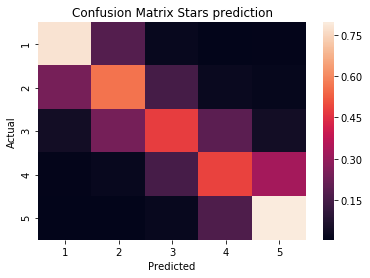

In [84]:
all_preds = np.array(all_preds)
print(all_preds.shape)
y_predictions = all_preds.argmax(axis=1)
y_true = y_test.argmax(axis=1)
y_true = y_true[:len(y_predictions)]

cm = ConfusionMatrix(y_true, y_predictions)
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))

test_correctPred = np.equal(y_predictions, y_true)
test_accuracy = np.mean(test_correctPred.astype(float))

print(test_accuracy)

# Test out the network yourself!
User can enter a review here and see how the network does in predicting his or her review

In [87]:
load_files = True
if load_files == True:
    word_embedding_matrix = loadfiles("./data/pickles/word_embedding_matrix.p")
    word2int = loadfiles('./data/pickles/word2int.p')

pred_text = input("Please enter a review in english")
contractions = get_contractions()
pred_text = clean_text(pred_text)
pred_seq = convert_to_ints(pred_text, pred=True)
pred_seq = np.tile(pred_seq, (batch_size, 1))

with tf.Session(graph=train_graph) as sess:
    checkpoint = "./saves/best_model.ckpt"  
    all_preds = []
    with tf.Session() as sess:
        saver = tf.train.Saver()
        # Load the model
        saver.restore(sess, checkpoint)
        test_state = sess.run(graph.initial_state)
        feed = {graph.input_data: pred_seq,
                graph.keep_prob: keep_probability,
                graph.initial_state: state}

        predictions = sess.run(graph.predictions, feed_dict=feed)
        for i in range(len(predictions)):
            all_preds.append(predictions[i,:])
all_preds = np.array(all_preds)
y_predictions = all_preds.argmax(axis=1)
counts = np.bincount(y_predictions)
print("\nYou rated the restaurant: " + str(np.argmax(counts)) + " stars!")

Please enter a review in englishI love this place! Will definitely come back!
INFO:tensorflow:Restoring parameters from ./saves/best_model.ckpt

You rated the restaurant: 5 stars!
